In [79]:
import numpy as np
import pandas as pd
import glob, os
from scipy.stats import norm
import matplotlib.pyplot as plt

--- **Data Aggregation and Cleaning were here** ---

Initially this script included lines meant for data aggregation and cleaning. As the process is going to be the same for all upcoming scripts, these lines are deleted. However, they can be found in the first script related to Safety and Cycle Stock calculation.

--- **Cost and Service Level Optimization script starts here** ---

Product chosen for this script is one of supplier's topsellers. It's is rarely included in promo activities.

In [98]:
dfPivot = dfPivot[dfPivot['Base_Unit_Code']=='1234567890']

Data sample for the chosen product is displayed below.

In [99]:
print(dfPivot.sample(5))

Line_ID Movement_Week Movement_Date       EAN_Code Base_Unit_Code   Stock  Transit  Shipped  OOS  Demand
6                cw05    2021-02-01  4600000000001     1234567890  117139    17172    11331    0   11331
445              cw03    2021-01-20  4600000000001     1234567890   20796    36720    17532    0   17532
3969             cw42    2020-10-13  4600000000001     1234567890   28675    22032     8793    0    8793
3718             cw43    2020-10-20  4600000000001     1234567890   69933        0    11664    0   11664
3315             cw44    2020-11-01  4600000000001     1234567890   53264     4320     5067    0    5067


We choose calendar week as a period. 

In [100]:
dfOneProduct = dfPivot.groupby('Movement_Week',as_index=False)[['Stock','Shipped','OOS','Demand']].sum()

Aggregated quantities can be observed in the following table.

In [101]:
print(dfOneProduct[['Movement_Week','Demand']].tail(10))

Line_ID Movement_Week  Demand
16               cw44   41607
17               cw45   37393
18               cw46   62100
19               cw47   60111
20               cw48   94296
21               cw49   75029
22               cw50   69098
23               cw51    9144
24               cw52   27278
25               cw53   53959


*MU* is a mean value for product's demand. In our case it's calculated based on data since August 16th.

In [102]:
mu = np.round(dfOneProduct['Demand'].mean(),decimals=2) # mean value

*Sigma (std)* is standard deviation value for product's demand.

In [103]:
std = np.round((np.std(dfOneProduct['Demand'],ddof=1)),decimals=2) # standard deviation or std

In [104]:
print('\n','mu:',mu,'\n','std:',std)


 mu: 48699.31 
 std: 20484.33


In [105]:
def normal_loss_standard(x):                                          # function calculates the amount of units
    return norm.pdf(x) - x*(1-norm.cdf(x))                            # you're likely to run short.                      

def cost(h,d_mu,R,z,x_std,k,b):                                       # function calculates the inventory cost based on
    return h*(mu*R/2+z*x_std)+k/R+b*x_std*normal_loss_standard(z)/R   # the inputs below  

def CSL_optimal(b,h,R):                                               # function calculates 
    return 1-(h*R)/b                                                  # the optimal cycle service level - alpha
    

h = 1.25    # holding cost per week per unit
R = 1       # review period in weeks
L = 0.43    # lead time in weeks (here we have the equivalent of 3 days)
k = 1000    # transaction cost
b = 50      # backorder cost per unit


df = pd.DataFrame(columns=["Review Period", "Inventory Cost", "Cycle Service Level", "Fill Rate"])
for R in [1,2,3,4,5,6,7]:        # cost and service level are calculated per each review period
    x_std = 25*np.sqrt(R+L)
    alpha = CSL_optimal(b,h,R)
    z = norm.ppf(alpha)
    beta = 1 - x_std*normal_loss_standard(z)/R/mu
    df = df.append({"Cycle Service Level":np.round(alpha*100,decimals=2), 
                    "Fill Rate":np.round(beta*100,decimals=4), 
                    "Inventory Cost":np.round(cost(h,mu,R,z,x_std,k,b),decimals=2), 
                    "Review Period":R},
                     ignore_index=True)

print(df)

   Review Period  Inventory Cost  Cycle Service Level  Fill Rate
0            1.0        31524.43                 97.5    99.9994
1            2.0        61474.62                 95.0    99.9992
2            3.0        91753.77                 92.5    99.9989
3            4.0       122113.71                 90.0    99.9987
4            5.0       152505.27                 87.5    99.9985
5            6.0       182912.25                 85.0    99.9983
6            7.0       213327.81                 82.5    99.9981


In the table above we can see which inventory cost, cycle service level and fill rate we can expect with any proposed review period.

The plot below provides a clear overview of the chart.

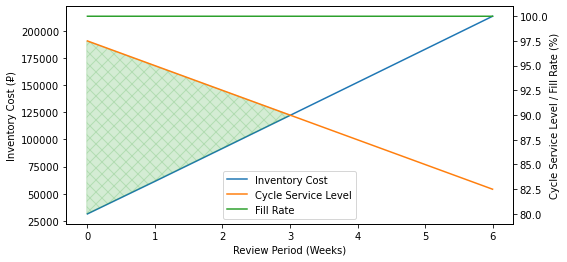

In [106]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

df[["Inventory Cost","Cycle Service Level","Fill Rate"]].plot(ax=ax_left,
                                                              figsize=(8,4),
                                                              secondary_y= ["Cycle Service Level","Fill Rate"])


ax_left.set_xlabel('Review Period (Weeks)')
ax_left.set_ylabel('Inventory Cost (₽)')
ax_right.set_ylabel('Cycle Service Level / Fill Rate (%)',labelpad=37)
ax_right.set_yticks([])

h1, l1 = ax_left.get_legend_handles_labels()             # next 5 lines let us add a legend block to the lower center
h2, l2 = ax_left.right_ax.get_legend_handles_labels()
handles = h1+h2
labels = l1+l2
ax_left.legend(handles, labels, loc=8, ncol=1)

x1, y1, y2 = [-0.01,3], [97.5,90], [80,90]               # coordinates of the area that shows the suitable range for
                                                         # inventory cost and cycle service level

plt.fill_between(x1, y1, y2, color='C2', alpha=0.2, hatch='xx')  # the chosen area above is filled with color

plt.show()

The plot above displays that it would be profitable to keep the review period within 3 days. There will be a balance between cycle service level and inventory cost. 

The best result is achieved with the shortest possible review period. Fill rate remains high with any review period.

When review period is extended, it will cause negative effect in both costs and service level.